# Lid-driven cavity

- Batched simulation for lid-driven cavity with noise added to form different steady-state solutions.

In [1]:
import torch
import torch_cfd.finite_differences as fdm
from torch_cfd import advection, boundaries, grids

from torch_cfd.fvm import NavierStokes2DFVMProjection, RKStepper, PressureProjection
from torch_cfd.initial_conditions import velocity_field
from tqdm import tqdm

import xarray
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
x_velocity_fn = lambda x, y: torch.zeros_like(x)
y_velocity_fn = lambda x, y: torch.zeros_like(x)

nx = 128
ny = 128
density = 1.0
dt = 1e-3
batch_size = 8
viscosity = 1 / 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
T = 2.0
num_steps = int(T / dt)
update_steps = 20
diam = 1

grid = grids.Grid((nx, ny), domain=((0, diam), (0, diam)), device=device)

def top_boundary(x, y):
    return 4 * x * (1 - x)

def zeros(x, y):
    return torch.zeros_like(x)


u_bc = boundaries.FunctionBoundaryConditions(
            types=((boundaries.BCType.DIRICHLET, boundaries.BCType.DIRICHLET),
                   (boundaries.BCType.DIRICHLET, boundaries.BCType.DIRICHLET)),
            values=((zeros, zeros), (zeros, top_boundary)),
            grid=grid,
            offset=(1.0, 0.5),
        )

v_bc = boundaries.dirichlet_boundary_conditions(2, bc_values=((0.0, 0.0), (0.0, 0.0)))

v_bc = (u_bc, v_bc)

x_velocity_fn = lambda x, y: torch.zeros_like(x)
y_velocity_fn = lambda x, y: torch.zeros_like(x)


In [3]:
v0 = velocity_field(
    (x_velocity_fn, y_velocity_fn),
    grid,
    velocity_bc=v_bc,
    batch_size=batch_size,
    random_state=42,
    noise=0.2,
    device=device
)

pressure_bc = boundaries.get_pressure_bc_from_velocity(v0)

pressure_proj = PressureProjection(
            grid=grid,
            bc=pressure_bc,
            implementation='matmul')

convection = advection.ConvectionVector(grid=grid,
                                        offsets=(v0[0].offset, v0[1].offset),
                                        bcs=v_bc,
                                        advect=advection.AdvectionUpwind)

step_fn = RKStepper.from_method(method="classic_rk4", 
                                requires_grad=False,
                                dtype=torch.float64)

ns2d = NavierStokes2DFVMProjection(
    viscosity=viscosity,
    grid=grid,
    bcs=v_bc,
    density=density,
    step_fn=step_fn,
    pressure_proj=pressure_proj,
    convection=convection,
).to(v0.device)

In [4]:
v = v0

trajectory = [[], []]
nan_count = 0
velocity_norm = torch.sqrt(v[0].L2norm**2 + v[1].L2norm**2)
divergence = fdm.divergence(v)[1:-1, 1:-1]
desc = f"u norm: {velocity_norm.mean().item():.3e} | div norm: {divergence.L2norm.mean().item():.3e}"

with tqdm(total=num_steps, desc=desc) as pbar:
    with torch.no_grad():
        for i in range(num_steps):
            v, p = ns2d(v, dt)
            if torch.isnan(v[0].data).any():
                print(f"NaN detected at step {i}")
                nan_count += 1
                break

            if (i + 1) % update_steps == 0:
                velocity_norm = torch.sqrt(v[0].L2norm**2 + v[1].L2norm**2)
                divergence = fdm.divergence(v)[1:-1, 1:-1]
                desc = f"u norm: {velocity_norm.mean().item():.3e} | div norm: {divergence.L2norm.mean().item():.3e}"
                if nan_count > 0:
                    break
                trajectory[0].append(v[0].data.detach().cpu().numpy())
                trajectory[1].append(v[1].data.detach().cpu().numpy())
            
            pbar.set_description(desc)
            pbar.update()

u norm: 1.453e-01 | div norm: 6.446e-03: 100%|██████████| 2000/2000 [00:55<00:00, 36.26it/s]


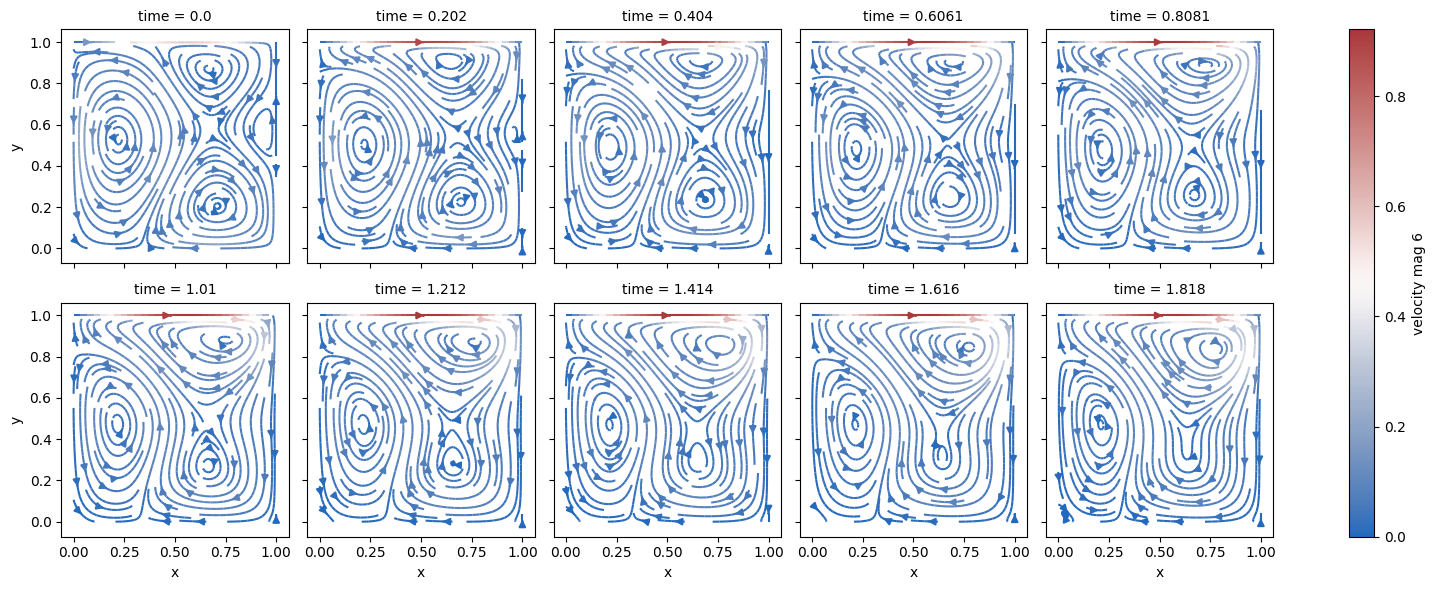

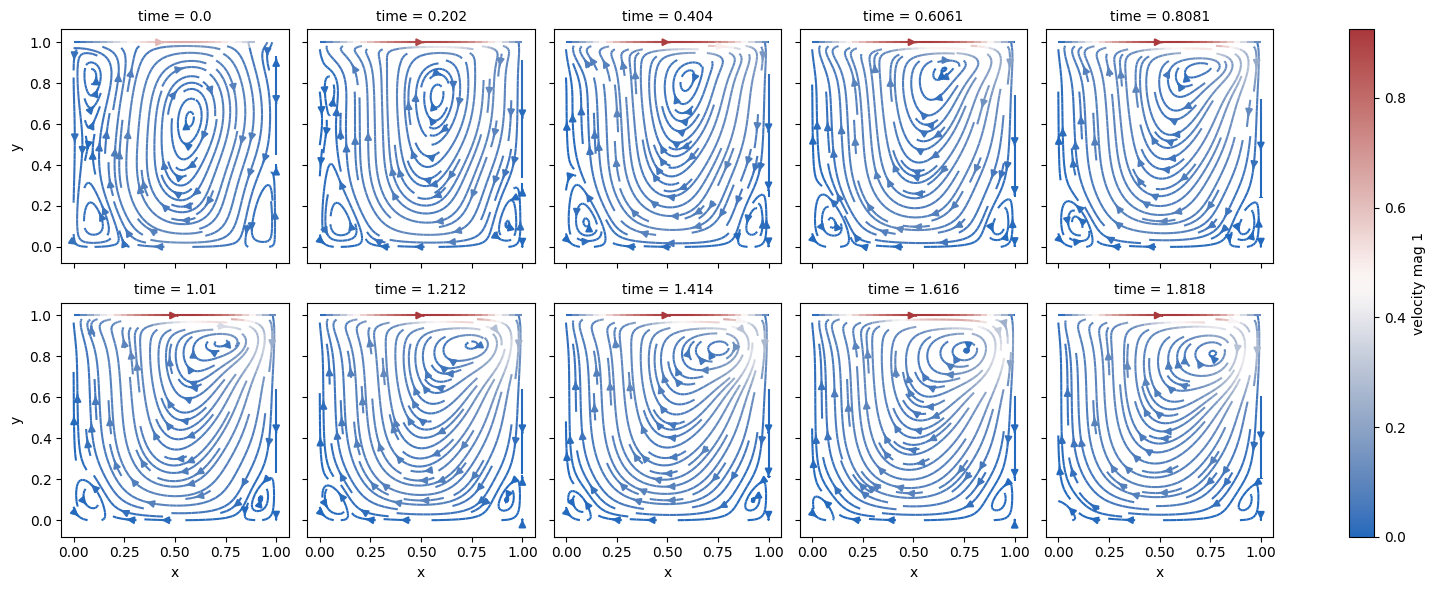

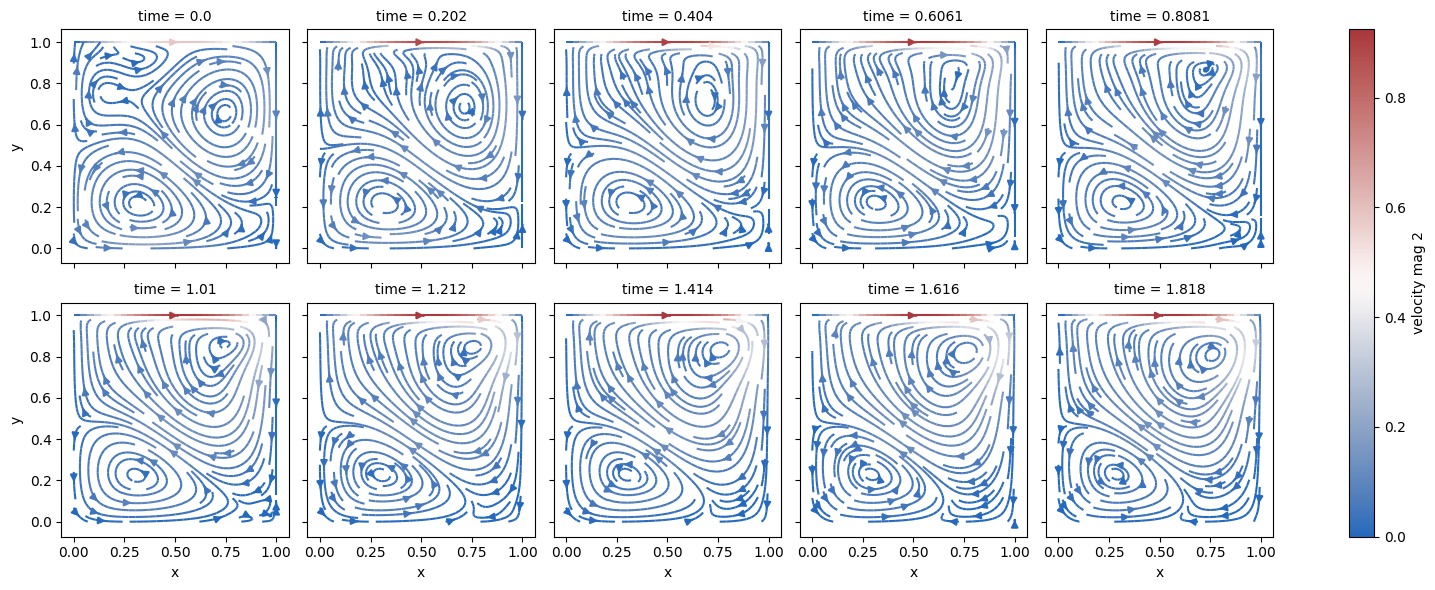

In [5]:
trajectory_plot = np.stack(trajectory).astype(np.float64)

idxes = np.random.choice(np.arange(batch_size), size=3, replace=False)

coords = {
    "time": np.linspace(0, T, trajectory_plot.shape[1], dtype=np.float64),
    "x": np.linspace(0, 1, nx, dtype=np.float64),
    "y": np.linspace(0, 1, ny, dtype=np.float64),
}

for idx in idxes:
    u_data = xarray.DataArray(
        trajectory_plot[0, :, idx], dims=["time", "x", "y"], coords=coords
    ).to_dataset(name="u")

    v_data = xarray.DataArray(
        trajectory_plot[1, :, idx], dims=["time", "x", "y"], coords=coords
    ).to_dataset(name="v")

    velocity_mag = np.sqrt((trajectory_plot[:, :, idx] ** 2).sum(axis=0))

    vmag_data = xarray.DataArray(
        velocity_mag, dims=["time", "x", "y"], coords=coords
    ).to_dataset(name=f"velocity mag {idx}")

    data = xarray.merge([u_data, v_data, vmag_data])


    g = (
        data.thin(time=10)
        .plot.streamplot(
            x="x",
            y="y",
            u="u",
            v="v",
            hue=f"velocity mag {idx}",
            col="time",
            col_wrap=5,
            cmap=sns.cm.vlag,
        )
    )